In [108]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon

In [109]:
df1 = pd.read_csv("bird_roi_abs.csv", index_col=0)
df2 = pd.read_csv("mavic_roi_abs.csv", index_col=0)

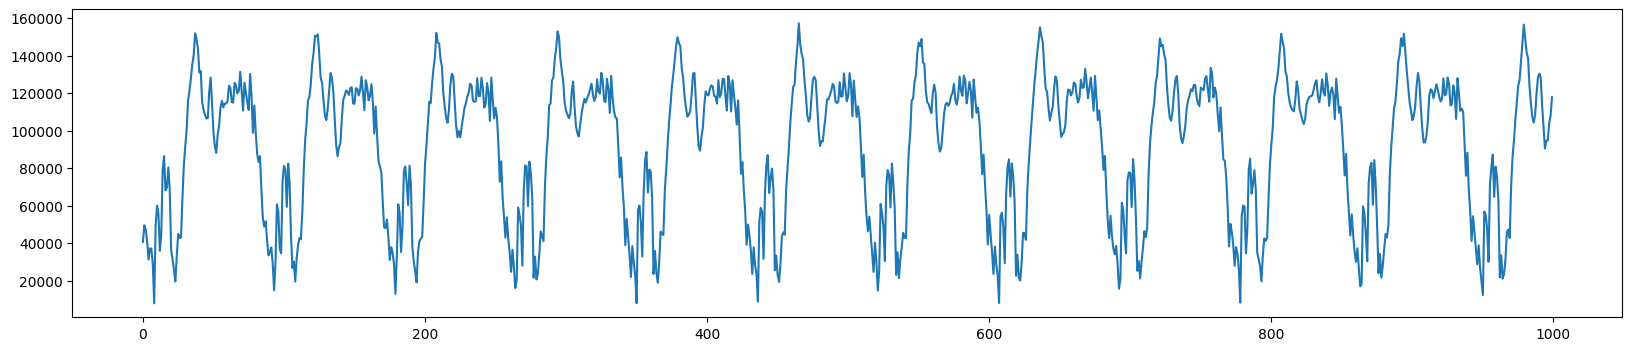

In [110]:
plt.figure(figsize=(20, 4))
plt.plot(df1)
plt.show()

# plt.figure(figsize=(20, 4))
# plt.plot(df2)
# plt.show()

In [111]:
n_points = 2000
eps = 1e-3
noise_std = 0.2

h_start = 0.1
h_min = 0.001
a = np.sqrt(2)

In [112]:
x = np.linspace(eps, 1.0, n_points)
y_clean = (1 + 0.5 * np.sin(4 * np.pi * x)) * np.sin(2 * np.pi * (6 * x + 12 * x**3))

np.random.seed(42)
noise = np.random.normal(scale=noise_std, size=n_points)
y_noisy = y_clean + noise

In [113]:


x = df1.index.to_numpy()
x = (x - x.min()) / (x.max() - x.min())
y_clean = df1.to_numpy()
y_noisy = df1.to_numpy()
n_points = len(x)

y_clean = df1.iloc[:, 0].to_numpy()
y_noisy = df1.iloc[:, 0].to_numpy()

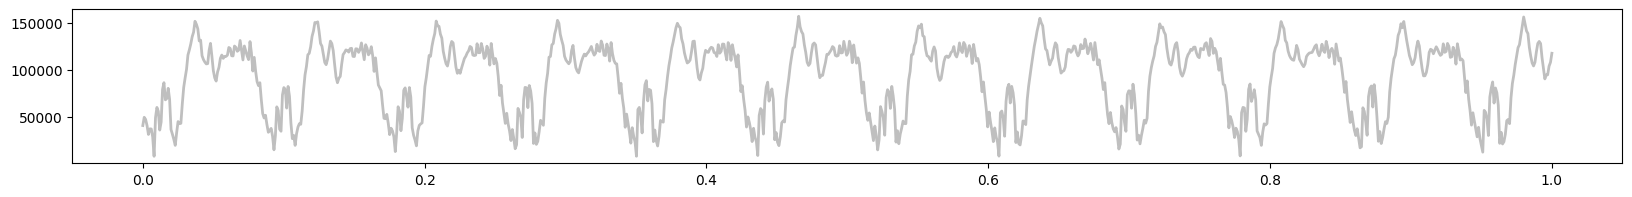

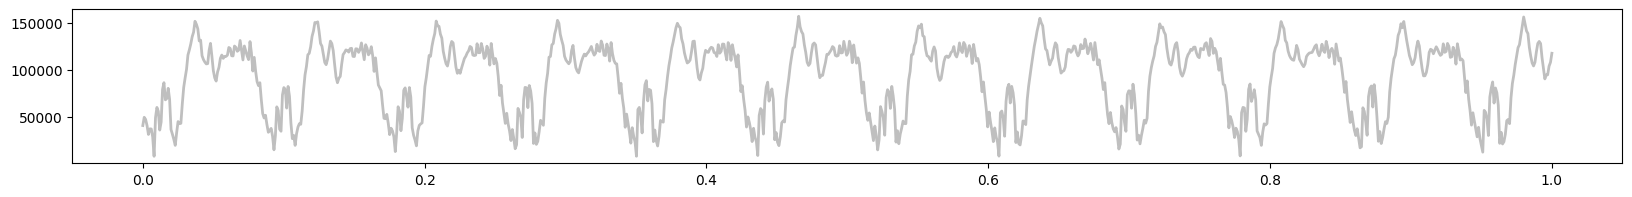

In [114]:
plt.figure(figsize=(20, 2))
plt.plot(x, y_clean, color='gray', linewidth=2, alpha=0.5)
# plt.ylim(-2.5, 2.5)
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
# plt.ylim(-2.5, 2.5)
plt.show()

In [115]:
residuals_list = []
components = []
current_residuals = y_noisy.copy()
h_curr = h_start

count = 0
while h_curr >= h_min:
    count += 1
    print("Step", count, "| h =", round(h_curr, 4))
    n = len(x)
    y_smooth = np.zeros(n)
    
    for i in range(n):
        t = x[i]
        
        indices = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]        # Rolling Window
        local_res = current_residuals[indices]
            
        u = (x[indices] - t) / h_curr                                       # s - t / h
        weights = 0.75 * (1 - u**2)                                         # Epanechnikov Kernel
        weights[weights < 0] = 0
        weights = weights / (weights.sum())
        # print(weights.sum())
        
        def loss_function(m):
            return np.sum(np.abs(local_res - m) * weights)
        result = minimize_scalar(loss_function)
    
        if result.success:
            y_smooth[i] = result.x
        
    components.append(y_smooth)
    current_residuals = current_residuals - y_smooth
    #very important added by Marc in order to have the residuals from which we create the next IMF
    residuals_list.append(current_residuals)
    h_curr = h_curr / a

print()

###############################################


residuals_list_clean=[]
components_clean = []
current_residuals_clean = y_clean.copy()
h_curr = h_start

count = 0
while h_curr >= h_min:
    count += 1
    print("Step", count, "| h =", round(h_curr, 4))
    n = len(x)
    y_smooth = np.zeros(n)
    
    for i in range(n):
        t = x[i]
        
        indices = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]            # Rolling Window
        local_res = current_residuals_clean[indices]
            
        u = (x[indices] - t) / h_curr                                           # s - t / h
        weights = 0.75 * (1 - u**2)                                             # Epanechnikov Kernel
        weights = weights / (weights.sum())
        
        def loss_function(m):
            return np.sum(np.abs(local_res - m) * weights)
        result = minimize_scalar(loss_function)
    
        if result.success:
            y_smooth[i] = result.x
        
    components_clean.append(y_smooth)
    current_residuals_clean = current_residuals_clean - y_smooth
    #very important added by Marc in order to have the residuals from which we create the next IMF
    residuals_list_clean.append(current_residuals_clean)
    h_curr = h_curr / a

Step 1 | h = 0.1
Step 2 | h = 0.0707
Step 3 | h = 0.05
Step 4 | h = 0.0354
Step 5 | h = 0.025
Step 6 | h = 0.0177
Step 7 | h = 0.0125
Step 8 | h = 0.0088
Step 9 | h = 0.0062
Step 10 | h = 0.0044
Step 11 | h = 0.0031
Step 12 | h = 0.0022
Step 13 | h = 0.0016
Step 14 | h = 0.0011

Step 1 | h = 0.1
Step 2 | h = 0.0707
Step 3 | h = 0.05
Step 4 | h = 0.0354
Step 5 | h = 0.025
Step 6 | h = 0.0177
Step 7 | h = 0.0125
Step 8 | h = 0.0088
Step 9 | h = 0.0062
Step 10 | h = 0.0044
Step 11 | h = 0.0031
Step 12 | h = 0.0022
Step 13 | h = 0.0016
Step 14 | h = 0.0011


In [116]:
def emd_decompose(y_input, x, h_start, h_min, a):
    residuals_list = []
    components = []
    current_residuals = y_input.copy()
    h_curr = h_start
    count = 0

    while h_curr >= h_min:
        count += 1
        print(f"Step {count} | h = {h_curr:.4f}")
        n = len(x)
        y_smooth = np.zeros(n)

        for i in range(n):
            t = x[i]
            
            indices = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]    # Rolling Window
            local_res = current_residuals[indices]
                
            u = (x[indices] - t) / h_curr                                   # s - t / h
            weights = 0.75 * (1 - u**2)                                     # Epanechnikov Kernel
            weights = weights / (weights.sum())
            # print(weights.sum())
            
            def loss_function(m):
                return np.sum(np.abs(local_res - m) * weights)
            result = minimize_scalar(loss_function)
        
            if result.success:
                y_smooth[i] = result.x
            
        components.append(y_smooth)
        current_residuals = current_residuals - y_smooth

        residuals_list.append(current_residuals.copy())                     # Store residuals
        h_curr /= a
    
    return components, residuals_list


print("--- Decomposing Noisy Signal ---")
components, residuals_list = emd_decompose(y_noisy, x, h_start, h_min, a)

print()
print("--- Decomposing Clean Signal ---")
components_clean, residuals_list_clean = emd_decompose(y_clean, x, h_start, h_min, a)

--- Decomposing Noisy Signal ---
Step 1 | h = 0.1000
Step 2 | h = 0.0707
Step 3 | h = 0.0500
Step 4 | h = 0.0354
Step 5 | h = 0.0250
Step 6 | h = 0.0177
Step 7 | h = 0.0125
Step 8 | h = 0.0088
Step 9 | h = 0.0062
Step 10 | h = 0.0044
Step 11 | h = 0.0031
Step 12 | h = 0.0022
Step 13 | h = 0.0016
Step 14 | h = 0.0011

--- Decomposing Clean Signal ---
Step 1 | h = 0.1000
Step 2 | h = 0.0707
Step 3 | h = 0.0500
Step 4 | h = 0.0354
Step 5 | h = 0.0250
Step 6 | h = 0.0177
Step 7 | h = 0.0125
Step 8 | h = 0.0088
Step 9 | h = 0.0062
Step 10 | h = 0.0044
Step 11 | h = 0.0031
Step 12 | h = 0.0022
Step 13 | h = 0.0016
Step 14 | h = 0.0011


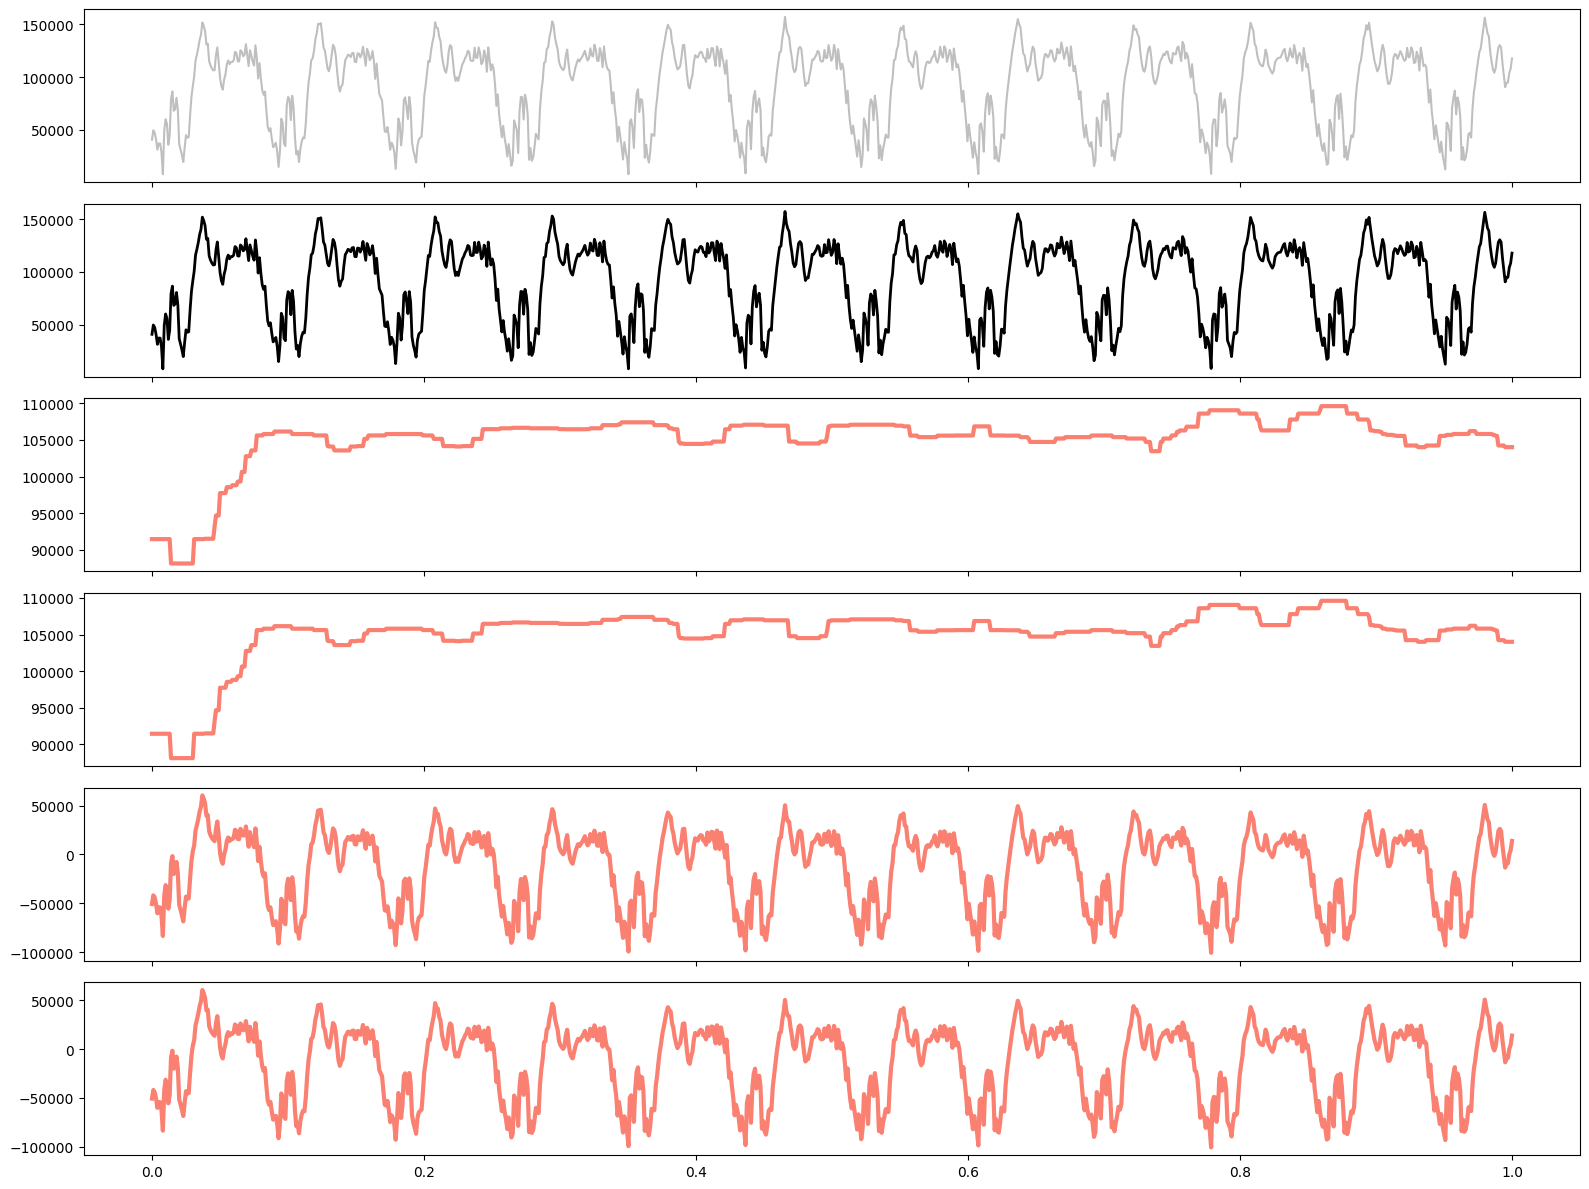

In [117]:
# 20260114 Work

iteration = 0

n_comp = len(components)
fig, axes = plt.subplots(6, 1, figsize=(16, 12), sharex=True)

ax = axes[0]
ax.plot(x, y_noisy, color='gray', linewidth=1.5, alpha=0.5)
# ax.set_ylim(-2.5, 2.5)

ax = axes[1]
ax.plot(x, y_clean, color='black', linestyle='-', linewidth=2)
# ax.set_ylim(-2.5, 2.5)

ax = axes[2]
ax.plot(x, components[0], color='salmon', linestyle='-', linewidth=3)
# ax.set_ylim(-2.5, 2.5)

ax = axes[3]
ax.plot(x, components_clean[0], color='salmon', linestyle='-', linewidth=3)
# ax.set_ylim(-0.5, 0.9)

ax = axes[4]
ax.plot(x, residuals_list[0], color='salmon', linestyle='-', linewidth=3)
# ax.set_ylim(-2.5, 2.5)

ax = axes[5]
ax.plot(x, residuals_list_clean[0], color='salmon', linestyle='-', linewidth=3)
# ax.set_ylim(-2.5, 2.5)

# y_reconstructed = np.zeros_like(x)

# for i, comp in enumerate(components):
#     ax = axes[i+1]
#     ax.plot(x, comp, color='red', linewidth=2)
#     ax.set_ylim(-2.5, 2.5)

#     y_reconstructed += comp

# ax = axes[-1]
# ax.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
# ax.plot(x, y_clean, color='black', linestyle='--', linewidth=1.5)
# ax.plot(x, y_reconstructed, color='red', linewidth=4)
# ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.savefig(f"EMD_Local_6panels_h{h_start}.png", dpi=144, transparent=False)
plt.show()

In [118]:
n_iterations = len(components)
print(f"Generating plots for {n_iterations} iterations...")

for i in range(n_iterations):
    fig, axes = plt.subplots(6, 1, figsize=(16, 12), sharex=True)

    if i == 0:
        current_input_noisy = y_noisy
        current_input_clean = y_clean
    else:
        current_input_noisy = residuals_list[i-1]
        current_input_clean = residuals_list_clean[i-1]

    # Panel 1: Input for this iteration (Noisy)
    ax = axes[0]
    ax.plot(x, current_input_noisy, color='gray', linewidth=1.5, alpha=0.5)
    # ax.set_ylim(-2.5, 2.5)

    # Panel 2: Input for this iteration (Clean)
    ax = axes[1]
    ax.plot(x, current_input_clean, color='black', linestyle='-', linewidth=2)
    # ax.set_ylim(-2.5, 2.5)

    # Panel 3: Component (Noisy) at iteration i
    ax = axes[2]
    ax.plot(x, components[i], color='salmon', linestyle='-', linewidth=3)
    # ax.set_ylim(-2.5, 2.5)

    # Panel 4: Component (Clean) at iteration i
    ax = axes[3]
    ax.plot(x, components_clean[i], color='salmon', linestyle='-', linewidth=3)
    # ax.set_ylim(-2.5, 2.5)

    # Panel 5: Residual (Noisy) at iteration i
    ax = axes[4]
    ax.plot(x, residuals_list[i], color='salmon', linestyle='-', linewidth=3)
    # ax.set_ylim(-2.5, 2.5)

    # Panel 6: Residual (Clean) at iteration i
    ax = axes[5]
    ax.plot(x, residuals_list_clean[i], color='salmon', linestyle='-', linewidth=3)
    # ax.set_ylim(-2.5, 2.5)

    plt.tight_layout()
    
    filename = f"EMD_Local_iteration_{i}_h_{h_start}.png"
    plt.savefig(filename, dpi=144, transparent=True)
    plt.close(fig) 
    
    print(f"Saved: {filename}")

Generating plots for 14 iterations...
Saved: EMD_Local_iteration_0_h_0.1.png
Saved: EMD_Local_iteration_1_h_0.1.png
Saved: EMD_Local_iteration_2_h_0.1.png
Saved: EMD_Local_iteration_3_h_0.1.png
Saved: EMD_Local_iteration_4_h_0.1.png
Saved: EMD_Local_iteration_5_h_0.1.png
Saved: EMD_Local_iteration_6_h_0.1.png
Saved: EMD_Local_iteration_7_h_0.1.png
Saved: EMD_Local_iteration_8_h_0.1.png
Saved: EMD_Local_iteration_9_h_0.1.png
Saved: EMD_Local_iteration_10_h_0.1.png
Saved: EMD_Local_iteration_11_h_0.1.png
Saved: EMD_Local_iteration_12_h_0.1.png
Saved: EMD_Local_iteration_13_h_0.1.png
